In [1]:
import ultralytics
import torch
import cv2
import numpy as np

## ultralytics and dataset generation

In [64]:
model = ultralytics.YOLO("yolov8n.pt")
pt_model = model.model

100%|██████████| 6.23M/6.23M [00:00<00:00, 51.2MB/s]


In [65]:
dummy_input = torch.randn(1, 3, 640, 480)
dummy_output = pt_model(dummy_input)
len(dummy_output), dummy_output[0].shape, len(dummy_output[1]), dummy_output[1][2].shape

(2, torch.Size([1, 84, 6300]), 3, torch.Size([1, 144, 20, 15]))

In [66]:
model(dummy_input)[0].boxes


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 5.217529773712158. Dividing input by 255.
0: 640x480 (no detections), 90.7ms
Speed: 0.5ms preprocess, 90.7ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 480)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (640, 480)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))

In [67]:
import pandas as pd
import os

#example_img = cv2.imread('cctv-data/train/images/gmd_1_frame6_jpg.rf.8856761f366d26ec58bffe9f89f70414.jpg')
#w, h, c = example_img.shape
#
#example_bbox = open(file='cctv-data/train/labels/gmd_1_frame6_jpg.rf.8856761f366d26ec58bffe9f89f70414.txt', mode="r").read().split(' ')
video_directories = ['frame-data/0/', 'frame-data/1/', 'frame-data/4/']

# Prepare the data
data = {'video_name': [], 'images': [], 'labels': []}

# Iterate through each video directory
for video_dir in video_directories:
    images_path = os.path.join(video_dir, 'images/')
    labels_path = os.path.join(video_dir, 'labels/')
    
    # Get list of images
    if os.path.exists(images_path):
        images_list = []
        for img in sorted(os.listdir(images_path)):
            print(video_dir, img)
            if img.endswith('.png'):
                images_list.append(cv2.imread(os.path.join(images_path, img))/255)
    else:
        images_list = []
    
    # Get list of labels
    if os.path.exists(labels_path):
        labels_list = []
        for label in sorted(os.listdir(labels_path)):
            if label.endswith('.txt'):
                label = open(os.path.join(labels_path, label))
                lines = label.read().split('\n')
                print(lines)
                bboxes = []
                for line in lines:
                    bbox = line.split(' ')
                    bboxes.append(bbox)
                labels_list.append(bboxes)
                label.close()
    else:
        labels_list = []
    
    data['video_name'].append(video_dir.strip('/'))
    data['images'].append(images_list)
    data['labels'].append(labels_list)

# Create the dataframe
df = pd.DataFrame(data)
df.sample()

frame-data/0/ .DS_Store
frame-data/0/ frame000000.png
frame-data/0/ frame000001.png
frame-data/0/ frame000002.png
frame-data/0/ frame000003.png
frame-data/0/ frame000004.png
frame-data/0/ frame000005.png
frame-data/0/ frame000006.png
frame-data/0/ frame000007.png
frame-data/0/ frame000008.png
frame-data/0/ frame000009.png
frame-data/0/ frame000010.png
frame-data/0/ frame000011.png
frame-data/0/ frame000012.png
frame-data/0/ frame000013.png
frame-data/0/ frame000014.png
frame-data/0/ frame000015.png
frame-data/0/ frame000016.png
frame-data/0/ frame000017.png
frame-data/0/ frame000018.png
frame-data/0/ frame000019.png
frame-data/0/ frame000020.png
frame-data/0/ frame000021.png
frame-data/0/ frame000022.png
frame-data/0/ frame000023.png
frame-data/0/ frame000024.png
frame-data/0/ frame000025.png
frame-data/0/ frame000026.png
frame-data/0/ frame000027.png
frame-data/0/ frame000028.png
frame-data/0/ frame000029.png
frame-data/0/ frame000030.png
frame-data/0/ frame000031.png
frame-data/0/ fr

KeyboardInterrupt: 

In [ ]:
df.loc[2, 'labels'][0]

[['']]

## custom yolov8

In [3]:
import math

import torch


def make_anchors(x, strides, offset=0.5):
    """
    Generate anchors from features
    """
    assert x is not None
    anchor_points, stride_tensor = [], []
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, dtype=x[i].dtype, device=x[i].device) + offset  # shift x
        sy = torch.arange(end=h, dtype=x[i].dtype, device=x[i].device) + offset  # shift y
        sy, sx = torch.meshgrid(sy, sx)
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=x[i].dtype, device=x[i].device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)



def pad(k, p=None, d=1):
    if d > 1:
        k = d * (k - 1) + 1
    if p is None:
        p = k // 2
    return p


def fuse_conv(conv, norm):
    fused_conv = torch.nn.Conv2d(conv.in_channels,
                                 conv.out_channels,
                                 kernel_size=conv.kernel_size,
                                 stride=conv.stride,
                                 padding=conv.padding,
                                 groups=conv.groups,
                                 bias=True).requires_grad_(False).to(conv.weight.device)

    w_conv = conv.weight.clone().view(conv.out_channels, -1)
    w_norm = torch.diag(norm.weight.div(torch.sqrt(norm.eps + norm.running_var)))
    fused_conv.weight.copy_(torch.mm(w_norm, w_conv).view(fused_conv.weight.size()))

    b_conv = torch.zeros(conv.weight.size(0), device=conv.weight.device) if conv.bias is None else conv.bias
    b_norm = norm.bias - norm.weight.mul(norm.running_mean).div(torch.sqrt(norm.running_var + norm.eps))
    fused_conv.bias.copy_(torch.mm(w_norm, b_conv.reshape(-1, 1)).reshape(-1) + b_norm)

    return fused_conv


class Conv(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=1, s=1, p=None, d=1, g=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, k, s, pad(k, p, d), d, g, False)
        self.norm = torch.nn.BatchNorm2d(out_ch, 0.001, 0.03)
        self.relu = torch.nn.SiLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

    def fuse_forward(self, x):
        return self.relu(self.conv(x))


class Residual(torch.nn.Module):
    def __init__(self, ch, add=True):
        super().__init__()
        self.add_m = add
        self.res_m = torch.nn.Sequential(Conv(ch, ch, 3),
                                         Conv(ch, ch, 3))

    def forward(self, x):
        return self.res_m(x) + x if self.add_m else self.res_m(x)


class CSP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, n=1, add=True):
        super().__init__()
        self.conv1 = Conv(in_ch, out_ch // 2)
        self.conv2 = Conv(in_ch, out_ch // 2)
        self.conv3 = Conv((2 + n) * out_ch // 2, out_ch)
        self.res_m = torch.nn.ModuleList(Residual(out_ch // 2, add) for _ in range(n))

    def forward(self, x):
        y = [self.conv1(x), self.conv2(x)]
        y.extend(m(y[-1]) for m in self.res_m)
        return self.conv3(torch.cat(y, dim=1))


class SPP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.conv1 = Conv(in_ch, in_ch // 2)
        self.conv2 = Conv(in_ch * 2, out_ch)
        self.res_m = torch.nn.MaxPool2d(k, 1, k // 2)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.res_m(x)
        y2 = self.res_m(y1)
        return self.conv2(torch.cat([x, y1, y2, self.res_m(y2)], 1))


class DarkNet(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        p1 = [Conv(width[0], width[1], 3, 2)]
        p2 = [Conv(width[1], width[2], 3, 2),
              CSP(width[2], width[2], depth[0])]
        p3 = [Conv(width[2], width[3], 3, 2),
              CSP(width[3], width[3], depth[1])]
        p4 = [Conv(width[3], width[4], 3, 2),
              CSP(width[4], width[4], depth[2])]
        p5 = [Conv(width[4], width[5], 3, 2),
              CSP(width[5], width[5], depth[0]),
              SPP(width[5], width[5])]

        self.p1 = torch.nn.Sequential(*p1)
        self.p2 = torch.nn.Sequential(*p2)
        self.p3 = torch.nn.Sequential(*p3)
        self.p4 = torch.nn.Sequential(*p4)
        self.p5 = torch.nn.Sequential(*p5)

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(p1)
        p3 = self.p3(p2)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        return p3, p4, p5


class DarkFPN(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        self.up = torch.nn.Upsample(None, 2)
        self.h1 = CSP(width[4] + width[5], width[4], depth[0], False)
        self.h2 = CSP(width[3] + width[4], width[3], depth[0], False)
        self.h3 = Conv(width[3], width[3], 3, 2)
        self.h4 = CSP(width[3] + width[4], width[4], depth[0], False)
        self.h5 = Conv(width[4], width[4], 3, 2)
        self.h6 = CSP(width[4] + width[5], width[5], depth[0], False)

    def forward(self, x):
        p3, p4, p5 = x
        h1 = self.h1(torch.cat([self.up(p5), p4], 1))
        h2 = self.h2(torch.cat([self.up(h1), p3], 1))
        h4 = self.h4(torch.cat([self.h3(h2), h1], 1))
        h6 = self.h6(torch.cat([self.h5(h4), p5], 1))
        return h2, h4, h6


class DFL(torch.nn.Module):
    # Integral module of Distribution Focal Loss (DFL)
    # Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    def __init__(self, ch=16):
        super().__init__()
        self.ch = ch
        self.conv = torch.nn.Conv2d(ch, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(ch, dtype=torch.float).view(1, ch, 1, 1)
        self.conv.weight.data[:] = torch.nn.Parameter(x)

    def forward(self, x):
        b, c, a = x.shape
        x = x.view(b, 4, self.ch, a).transpose(2, 1)
        return self.conv(x.softmax(1)).view(b, 4, a)


class Head(torch.nn.Module):
    anchors = torch.empty(0)
    strides = torch.empty(0)

    def __init__(self, nc=80, filters=()):
        super().__init__()
        self.ch = 16  # DFL channels
        self.nc = nc  # number of classes
        self.nl = len(filters)  # number of detection layers
        self.no = nc + self.ch * 4  # number of outputs per anchor
        self.stride = torch.zeros(self.nl)  # strides computed during build

        c1 = max(filters[0], self.nc)
        c2 = max((filters[0] // 4, self.ch * 4))

        self.dfl = DFL(self.ch)
        self.cls = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, c1, 3),
                                                           Conv(c1, c1, 3),
                                                           torch.nn.Conv2d(c1, self.nc, 1)) for x in filters)
        self.box = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, c2, 3),
                                                           Conv(c2, c2, 3),
                                                           torch.nn.Conv2d(c2, 4 * self.ch, 1)) for x in filters)

    def forward(self, x):
        for i in range(self.nl):
            x[i] = torch.cat((self.box[i](x[i]), self.cls[i](x[i])), 1)
        if self.training:
            return x
        self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))

        x = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        box, cls = x.split((self.ch * 4, self.nc), 1)
        a, b = torch.split(self.dfl(box), 2, 1)
        a = self.anchors.unsqueeze(0) - a
        b = self.anchors.unsqueeze(0) + b
        box = torch.cat(((a + b) / 2, b - a), 1)
        return torch.cat((box * self.strides, cls.sigmoid()), 1)

    def initialize_biases(self):
        # Initialize biases
        # WARNING: requires stride availability
        m = self
        for a, b, s in zip(m.box, m.cls, m.stride):
            a[-1].bias.data[:] = 1.0  # box
            # cls (.01 objects, 80 classes, 640 img)
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)


class YOLO(torch.nn.Module):
    def __init__(self, width, depth, num_classes):
        super().__init__()
        self.net = DarkNet(width, depth)
        self.fpn = DarkFPN(width, depth)

        img_dummy = torch.zeros(1, 3, 256, 256)
        self.head = Head(num_classes, (width[3], width[4], width[5]))
        self.head.stride = torch.tensor([256 / x.shape[-2] for x in self.forward(img_dummy)])
        self.stride = self.head.stride
        self.head.initialize_biases()

    def forward(self, x):
        x = self.net(x)
        P3, P4, P5 = self.fpn(x)
            
        P3_h, P4_h, P5_h = self.head(list(x))
        return P3_h, P4_h, P5_h

    def fuse(self):
        for m in self.modules():
            if type(m) is Conv and hasattr(m, 'norm'):
                m.conv = fuse_conv(m.conv, m.norm)
                m.forward = m.fuse_forward
                delattr(m, 'norm')
        return self

def yolo_v8_n(num_classes: int = 80):
    depth = [1, 2, 2]
    width = [3, 16, 32, 64, 128, 256]
    return YOLO(width, depth, num_classes)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def human_readable(num, dec=2):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return ('{:.' + str(dec) + 'f}{}').format(num, ['', 'K', 'M', 'B', 'T'][magnitude])

md = yolo_v8_n(num_classes=1)
human_readable(count_parameters(md))
expl = torch.randn(1, 3, 640, 480)
out = md(expl)

 ## and yolomamba

In [4]:
import torch
import torch.nn as nn

import torch
import torch.nn as nna
import torch.nn.functional as F
from scripts.mamba_block import MambaConfig, Mamba

class FeatureMap_Bottleneck(nn.Module):
    def __init__(self, embedding_size, n_layers_mamba=1, input_channels = 256, reduction = None):
        super(FeatureMap_Bottleneck, self).__init__()
        if reduction == None: reduction = embedding_size
        self.conv1 = nn.Conv2d(input_channels, reduction, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # Downscale by 2
        self.conv2 = nn.Conv2d(reduction, embedding_size, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Downscale by 2
        
        self.conv3 = nn.Conv2d(embedding_size, embedding_size, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(2*embedding_size, embedding_size, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(2*embedding_size, embedding_size, kernel_size=3, padding=1)  # Adjusted input channels
        self.upconv1 = nn.ConvTranspose2d(embedding_size, reduction, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(2*reduction, input_channels, kernel_size=3, padding=1)  # Adjusted input channels
        self.embedding_size = embedding_size

        config = MambaConfig(d_model=embedding_size, n_layers=n_layers_mamba)
        self.mamba = Mamba(config)

    def forward(self, x):
        # Downscale
        conv1_out = self.conv1(x)
        x = self.pool1(conv1_out)
        conv2_out = self.conv2(x)
        x = self.pool2(conv2_out)
        
        bottleneck = self.conv3(x)
        flat_bottleneck = F.adaptive_avg_pool2d(bottleneck, (1, 1))  # Shape: (S, C, 1, 1)
        frame_embedding = flat_bottleneck.reshape(S, self.embedding_size).unsqueeze(0)
        
        frame_embedding = self.mamba(frame_embedding)

        frame_embedding = frame_embedding.squeeze().unsqueeze(-1).unsqueeze(-1)
        
        x = self.crop_and_concat(frame_embedding, bottleneck)
        x = self.upconv2(x)
        x = self.crop_and_concat(x, conv2_out)
        x = self.conv4(x)
        x = self.upconv1(x)
        x = self.crop_and_concat(x, conv1_out)
        x = self.conv5(x)
        
        return x

    def crop_and_concat(self, upsampled, bypass):
        """
        Crop the downsampled feature map to match the size of the upsampled feature map and concatenate them.
        """
        _, _, h, w = bypass.size()
        upsampled = F.interpolate(upsampled, size=(h, w), mode='bilinear', align_corners=True)
        return torch.cat((upsampled, bypass), 1)


# Example usage
S = 4  # Batch size
input_tensor = torch.randn(S, 256, 20, 15)

bottleneck = FeatureMap_Bottleneck(embedding_size=64, n_layers_mamba=6)
print(human_readable(count_parameters(bottleneck)))
output_tensor = bottleneck(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)

835.84K
Input shape: torch.Size([4, 256, 20, 15])
Output shape: torch.Size([4, 256, 20, 15])


In [5]:
class YOLO_Mamba(torch.nn.Module):
    def __init__(self, width, depth, num_classes, n_layers_mamba, embedding_size=64):
        super().__init__()
        self.net = DarkNet(width, depth)
        self.fpn = DarkFPN(width, depth)

        self.featuremap_bottleneck = FeatureMap_Bottleneck(input_channels=width[-1], embedding_size=embedding_size,
                                                            n_layers_mamba=n_layers_mamba)
        img_dummy = torch.zeros(1, 3, 256, 256)
        self.head = Head(num_classes, (width[3], width[4], width[5]))
        self.head.stride = torch.tensor([256 / x.shape[-2] for x in self.forward(img_dummy)])
        self.stride = self.head.stride
        self.head.initialize_biases()

    def forward(self, x, sequential=False):
        x = self.net(x)
        P3, P4, P5 = self.fpn(x)
        
        if sequential:
            P5 = self.featuremap_bottleneck(P5)

        out = self.head(list(x))
        return out

    def fuse(self):
        for m in self.modules():
            if type(m) is Conv and hasattr(m, 'norm'):
                m.conv = fuse_conv(m.conv, m.norm)
                m.forward = m.fuse_forward
                delattr(m, 'norm')
        return self

def yolo_mamba_nano(num_classes: int = 80, n_layers_mamba=1, embedding_size=64):
    depth = [1, 2, 2]
    width = [3, 16, 32, 64, 128, 256]
    return YOLO_Mamba(width, depth, num_classes=num_classes, n_layers_mamba=n_layers_mamba, embedding_size=embedding_size)

wow = yolo_mamba_nano(num_classes=1, n_layers_mamba=6)
print(human_readable(count_parameters(wow)))

3.85M


In [6]:
input_tensor = torch.randn(S, 3, 640, 640)

wow.head.training = False
output_tensor = wow(input_tensor)

print("Input shape:", input_tensor.shape)

print("Output shape:", len(output_tensor),  output_tensor[2].shape)

Input shape: torch.Size([4, 3, 640, 640])
Output shape: 4 torch.Size([5, 8400])


/home/maxine/miniconda3/envs/louis/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## dataset class

In [7]:
import os 
os.listdir('weapon-dataset/images/train/')[:2]

['gmd_1_frame74_jpg.rf.97e64219df6d595ade4015d8b70b265f.jpg',
 'mock_attack_frame562_jpg.rf.45c430c44d9d58d134a3490c80a63795.jpg']

In [8]:
import math
import os
import random

import cv2
import numpy
import torch
from PIL import Image
from torch.utils import data

FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'

class Dataset(data.Dataset):
    def __init__(self, filedir, input_size, params, augment):

        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.input_size = input_size

        # Read labels
        filenames = [filedir + fname for fname in os.listdir(filedir) if fname.endswith(FORMATS)]
        cache = self.load_label(filenames)
        labels, shapes = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = numpy.array(shapes, dtype=numpy.float64)
        self.filenames = list(cache.keys())  # update
        self.n = len(shapes)  # number of samples
        self.indices = range(self.n)
        # Albumentations (optional, only used if package is installed)
        self.albumentations = Albumentations()

    def __getitem__(self, index):
        index = self.indices[index]

        params = self.params
        mosaic = self.mosaic and random.random() < params['mosaic']

        if mosaic:
            shapes = None
            # Load MOSAIC
            image, label = self.load_mosaic(index, params)
            # MixUp augmentation
            if random.random() < params['mix_up']:
                index = random.choice(self.indices)
                mix_image1, mix_label1 = image, label
                mix_image2, mix_label2 = self.load_mosaic(index, params)

                image, label = mix_up(mix_image1, mix_label1, mix_image2, mix_label2)
        else:
            # Load image
            image, shape = self.load_image(index)
            h, w = image.shape[:2]

            # Resize
            image, ratio, pad = resize(image, self.input_size, self.augment)
            shapes = shape, ((h / shape[0], w / shape[1]), pad) 

            label = self.labels[index].copy()
            if label.size:
                label[:, 1:] = wh2xy(label[:, 1:], ratio[0] * w, ratio[1] * h, pad[0], pad[1])
            if self.augment:
                image, label = random_perspective(image, label, params)
        nl = len(label)  # number of labels
        if nl:
            label[:, 1:5] = xy2wh(label[:, 1:5], image.shape[1], image.shape[0])

        if self.augment:
            # Albumentations
            image, label = self.albumentations(image, label)
            nl = len(label)  # update after albumentations
            # HSV color-space
            augment_hsv(image, params)
            # Flip up-down
            if random.random() < params['flip_ud']:
                image = numpy.flipud(image)
                if nl:
                    label[:, 2] = 1 - label[:, 2]
            # Flip left-right
            if random.random() < params['flip_lr']:
                image = numpy.fliplr(image)
                if nl:
                    label[:, 1] = 1 - label[:, 1]

        target = torch.zeros((nl, 6))
        if nl:
            target[:, 1:] = torch.from_numpy(label)

        # Convert HWC to CHW, BGR to RGB
        sample = image.transpose((2, 0, 1))[::-1]
        sample = numpy.ascontiguousarray(sample)

        return torch.from_numpy(sample), target, shapes

    def __len__(self):
        return len(self.filenames)

    def load_image(self, i):
        image = cv2.imread(self.filenames[i])
        h, w = image.shape[:2]
        r = self.input_size / max(h, w)
        if r != 1:
            image = cv2.resize(image,
                               dsize=(int(w * r), int(h * r)),
                               interpolation=resample() if self.augment else cv2.INTER_LINEAR)
        return image, (h, w)

    def load_mosaic(self, index, params):
        label4 = []
        image4 = numpy.full((self.input_size * 2, self.input_size * 2, 3), 0, dtype=numpy.uint8)
        y1a, y2a, x1a, x2a, y1b, y2b, x1b, x2b = (None, None, None, None, None, None, None, None)

        border = [-self.input_size // 2, -self.input_size // 2]

        xc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))
        yc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))

        indices = [index] + random.choices(self.indices, k=3)
        random.shuffle(indices)

        for i, index in enumerate(indices):
            # Load image
            image, _ = self.load_image(index)
            shape = image.shape
            if i == 0:  # top left
                x1a = max(xc - shape[1], 0)
                y1a = max(yc - shape[0], 0)
                x2a = xc
                y2a = yc
                x1b = shape[1] - (x2a - x1a)
                y1b = shape[0] - (y2a - y1a)
                x2b = shape[1]
                y2b = shape[0]
            if i == 1:  # top right
                x1a = xc
                y1a = max(yc - shape[0], 0)
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = yc
                x1b = 0
                y1b = shape[0] - (y2a - y1a)
                x2b = min(shape[1], x2a - x1a)
                y2b = shape[0]
            if i == 2:  # bottom left
                x1a = max(xc - shape[1], 0)
                y1a = yc
                x2a = xc
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = shape[1] - (x2a - x1a)
                y1b = 0
                x2b = shape[1]
                y2b = min(y2a - y1a, shape[0])
            if i == 3:  # bottom right
                x1a = xc
                y1a = yc
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = 0
                y1b = 0
                x2b = min(shape[1], x2a - x1a)
                y2b = min(y2a - y1a, shape[0])

            image4[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            pad_w = x1a - x1b
            pad_h = y1a - y1b

            # Labels
            label = self.labels[index].copy()
            if len(label):
                label[:, 1:] = wh2xy(label[:, 1:], shape[1], shape[0], pad_w, pad_h)
            label4.append(label)

        # Concat/clip labels
        label4 = numpy.concatenate(label4, 0)
        for x in label4[:, 1:]:
            numpy.clip(x, 0, 2 * self.input_size, out=x)

        # Augment
        image4, label4 = random_perspective(image4, label4, params, border)

        return image4, label4

    @staticmethod
    def collate_fn(batch):
        samples, targets, shapes = zip(*batch)
        for i, item in enumerate(targets):
            item[:, 0] = i  # add target image index
        return torch.stack(samples, 0), torch.cat(targets, 0), shapes

    @staticmethod
    def load_label(filenames):
        path = f'{os.path.dirname(filenames[0])}.cache'
        if os.path.exists(path):
            return torch.load(path)
        x = {}
        for filename in filenames:
                # verify images
                with open(filename, 'rb') as f:
                    image = Image.open(f)
                    image.verify()  # PIL verify
                shape = image.size  # image size
                assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
                assert image.format.lower() in FORMATS, f'invalid image format {image.format}'

                # verify labels
                a = f'{os.sep}images{os.sep}'
                b = f'{os.sep}labels{os.sep}'
                if os.path.isfile(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt'):
                    with open(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt') as f:
                        label = [x.split() for x in f.read().strip().splitlines() if len(x)]
                        label = numpy.array(label, dtype=numpy.float32)
                    nl = len(label)
                    if nl:
                        assert label.shape[1] == 5, 'labels require 5 columns'
                        assert (label >= 0).all(), 'negative label values'
                        assert (label[:, 1:] <= 1).all(), 'non-normalized coordinates'
                        _, i = numpy.unique(label, axis=0, return_index=True)
                        if len(i) < nl:  # duplicate row check
                            label = label[i]  # remove duplicates
                    else:
                        label = numpy.zeros((0, 5), dtype=numpy.float32)
                else:
                    label = numpy.zeros((0, 5), dtype=numpy.float32)
                if filename:
                    x[filename] = [label, shape]
        torch.save(x, path)
        return x

def wh2xy(x, w=640, h=640, pad_w=0, pad_h=0):
    # Convert nx4 boxes
    # from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = numpy.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + pad_w  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + pad_h  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + pad_w  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + pad_h  # bottom right y
    return y


def xy2wh(x, w=640, h=640):
    # warning: inplace clip
    x[:, [0, 2]] = x[:, [0, 2]].clip(0, w - 1E-3)  # x1, x2
    x[:, [1, 3]] = x[:, [1, 3]].clip(0, h - 1E-3)  # y1, y2

    # Convert nx4 boxes
    # from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    y = numpy.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y


def resample():
    choices = (cv2.INTER_AREA,
               cv2.INTER_CUBIC,
               cv2.INTER_LINEAR,
               cv2.INTER_NEAREST,
               cv2.INTER_LANCZOS4)
    return random.choice(seq=choices)


def augment_hsv(image, params):
    # HSV color-space augmentation
    h = params['hsv_h']
    s = params['hsv_s']
    v = params['hsv_v']

    r = numpy.random.uniform(-1, 1, 3) * [h, s, v] + 1
    h, s, v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

    x = numpy.arange(0, 256, dtype=r.dtype)
    lut_h = ((x * r[0]) % 180).astype('uint8')
    lut_s = numpy.clip(x * r[1], 0, 255).astype('uint8')
    lut_v = numpy.clip(x * r[2], 0, 255).astype('uint8')

    im_hsv = cv2.merge((cv2.LUT(h, lut_h), cv2.LUT(s, lut_s), cv2.LUT(v, lut_v)))
    cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=image)  # no return needed


def resize(image, input_size, augment):
    # Resize and pad image while meeting stride-multiple constraints
    shape = image.shape[:2]  # current shape [height, width]

    # Scale ratio (new / old)
    r = min(input_size / shape[0], input_size / shape[1])
    if not augment:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    pad = int(round(shape[1] * r)), int(round(shape[0] * r))
    w = (input_size - pad[0]) / 2
    h = (input_size - pad[1]) / 2

    if shape[::-1] != pad:  # resize
        image = cv2.resize(image,
                           dsize=pad,
                           interpolation=resample() if augment else cv2.INTER_LINEAR)
    top, bottom = int(round(h - 0.1)), int(round(h + 0.1))
    left, right = int(round(w - 0.1)), int(round(w + 0.1))
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)  # add border
    return image, (r, r), (w, h)


def candidates(box1, box2):
    # box1(4,n), box2(4,n)
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    aspect_ratio = numpy.maximum(w2 / (h2 + 1e-16), h2 / (w2 + 1e-16))  # aspect ratio
    return (w2 > 2) & (h2 > 2) & (w2 * h2 / (w1 * h1 + 1e-16) > 0.1) & (aspect_ratio < 100)


def random_perspective(samples, targets, params, border=(0, 0)):
    h = samples.shape[0] + border[0] * 2
    w = samples.shape[1] + border[1] * 2

    # Center
    center = numpy.eye(3)
    center[0, 2] = -samples.shape[1] / 2  # x translation (pixels)
    center[1, 2] = -samples.shape[0] / 2  # y translation (pixels)

    # Perspective
    perspective = numpy.eye(3)

    # Rotation and Scale
    rotate = numpy.eye(3)
    a = random.uniform(-params['degrees'], params['degrees'])
    s = random.uniform(1 - params['scale'], 1 + params['scale'])
    rotate[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    shear = numpy.eye(3)
    shear[0, 1] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)
    shear[1, 0] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)

    # Translation
    translate = numpy.eye(3)
    translate[0, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * w
    translate[1, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * h

    # Combined rotation matrix, order of operations (right to left) is IMPORTANT
    matrix = translate @ shear @ rotate @ perspective @ center
    if (border[0] != 0) or (border[1] != 0) or (matrix != numpy.eye(3)).any():  # image changed
        samples = cv2.warpAffine(samples, matrix[:2], dsize=(w, h), borderValue=(0, 0, 0))

    # Transform label coordinates
    n = len(targets)
    if n:
        xy = numpy.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ matrix.T  # transform
        xy = xy[:, :2].reshape(n, 8)  # perspective rescale or affine

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        new = numpy.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # clip
        new[:, [0, 2]] = new[:, [0, 2]].clip(0, w)
        new[:, [1, 3]] = new[:, [1, 3]].clip(0, h)

        # filter candidates
        indices = candidates(box1=targets[:, 1:5].T * s, box2=new.T)
        targets = targets[indices]
        targets[:, 1:5] = new[indices]

    return samples, targets


def mix_up(image1, label1, image2, label2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    alpha = numpy.random.beta(32.0, 32.0)  # mix-up ratio, alpha=beta=32.0
    image = (image1 * alpha + image2 * (1 - alpha)).astype(numpy.uint8)
    label = numpy.concatenate((label1, label2), 0)
    return image, label


class Albumentations:
    def __init__(self):
        self.transform = None
        try:
            import albumentations as album

            transforms = [album.Blur(p=0.01),
                          album.CLAHE(p=0.01),
                          album.ToGray(p=0.01),
                          album.MedianBlur(p=0.01)]
            self.transform = album.Compose(transforms,
                                           album.BboxParams('yolo', ['class_labels']))

        except ImportError:  # package not installed, skip
            pass

    def __call__(self, image, label):
        if self.transform:
            x = self.transform(image=image,
                               bboxes=label[:, 1:],
                               class_labels=label[:, 0])
            image = x['image']
            label = numpy.array([[c, *b] for c, b in zip(x['class_labels'], x['bboxes'])])
        return image, label
import yaml
with open(os.path.join('scripts', 'params.yaml'), errors='ignore') as f:
    params = yaml.safe_load(f)



dat = Dataset(filedir='weapon-dataset/images/train/', input_size=640,  params=params, augment=False)
it = dat.__getitem__(5)
len(it), it[0].shape, it[1], it[2]

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
/home/maxine/miniconda3/envs/louis/lib/python3.10/site-packages/albumentations/core/composition.py:151: UserWarning: Got processor for bboxes, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")


(3,
 torch.Size([3, 640, 640]),
 tensor([[0.0000, 0.0000, 0.5203, 0.4938, 0.0219, 0.0586]]),
 ((640, 640), ((1.0, 1.0), (0.0, 0.0))))

## the rest of utils

In [9]:
import copy
import math
import random
import time

import numpy
import torch
import torchvision
from torch.nn.functional import cross_entropy, one_hot


def setup_seed():
    """
    Setup random seed.
    """
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def setup_multi_processes():
    """
    Setup multi-processing environment variables.
    """
    import cv2
    from os import environ
    from platform import system

    # set multiprocess start method as `fork` to speed up the training
    if system() != 'Windows':
        torch.multiprocessing.set_start_method('fork', force=True)

    # disable opencv multithreading to avoid system being overloaded
    cv2.setNumThreads(0)

    # setup OMP threads
    if 'OMP_NUM_THREADS' not in environ:
        environ['OMP_NUM_THREADS'] = '1'

    # setup MKL threads
    if 'MKL_NUM_THREADS' not in environ:
        environ['MKL_NUM_THREADS'] = '1'


def scale(coords, shape1, shape2, ratio_pad=None):
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(shape1[0] / shape2[0], shape1[1] / shape2[1])  # gain  = old / new
        pad = (shape1[1] - shape2[1] * gain) / 2, (shape1[0] - shape2[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain

    coords[:, 0].clamp_(0, shape2[1])  # x1
    coords[:, 1].clamp_(0, shape2[0])  # y1
    coords[:, 2].clamp_(0, shape2[1])  # x2
    coords[:, 3].clamp_(0, shape2[0])  # y2
    return coords


def make_anchors(x, strides, offset=0.5):
    """
    Generate anchors from features
    """
    assert x is not None
    anchor_points, stride_tensor = [], []
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, dtype=x[i].dtype, device=x[i].device) + offset  # shift x
        sy = torch.arange(end=h, dtype=x[i].dtype, device=x[i].device) + offset  # shift y
        sy, sx = torch.meshgrid(sy, sx)
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=x[i].dtype, device=x[i].device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)


def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # intersection(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    intersection = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = intersection / (area1 + area2 - intersection)
    box1 = box1.T
    box2 = box2.T

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return intersection / (area1[:, None] + area2 - intersection)


def wh2xy_ut(x):
    y = x.clone()
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y


def non_max_suppression(prediction, conf_threshold=0.25, iou_threshold=0.45):
    nc = prediction.shape[1] - 4  # number of classes
    xc = prediction[:, 4:4 + nc].amax(1) > conf_threshold  # candidates

    # Settings
    max_wh = 7680  # (pixels) maximum box width and height
    max_det = 300  # the maximum number of boxes to keep after NMS
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()

    start = time.time()
    outputs = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for index, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        x = x.transpose(0, -1)[xc[index]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (box, conf, cls)
        box, cls = x.split((4, nc), 1)
        # center_x, center_y, width, height) to (x1, y1, x2, y2)
        box = wh2xy_ut(box)
        if nc > 1:
            i, j = (cls > conf_threshold).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_threshold]
        # Check shape
        if not x.shape[0]:  # no boxes
            continue
        # sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_threshold)  # NMS
        i = i[:max_det]  # limit detections
        outputs[index] = x[i]
        if (time.time() - start) > 0.5 + 0.05 * prediction.shape[0]:
            print(f'WARNING ⚠️ NMS time limit {0.5 + 0.05 * prediction.shape[0]:.3f}s exceeded')
            break  # time limit exceeded

    return outputs


def smooth(y, f=0.05):
    # Box filter of fraction f
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = numpy.ones(nf // 2)  # ones padding
    yp = numpy.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return numpy.convolve(yp, numpy.ones(nf) / nf, mode='valid')  # y-smoothed


def compute_ap(tp, conf, pred_cls, target_cls, eps=1e-16):
    """
    Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:  True positives (nparray, nx1 or nx10).
        conf:  Object-ness value from 0-1 (nparray).
        pred_cls:  Predicted object classes (nparray).
        target_cls:  True object classes (nparray).
    # Returns
        The average precision
    """
    # Sort by object-ness
    i = numpy.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = numpy.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    p = numpy.zeros((nc, 1000))
    r = numpy.zeros((nc, 1000))
    ap = numpy.zeros((nc, tp.shape[1]))
    px, py = numpy.linspace(0, 1, 1000), []  # for plotting
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        nl = nt[ci]  # number of labels
        no = i.sum()  # number of outputs
        if no == 0 or nl == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (nl + eps)  # recall curve
        # negative x, xp because xp decreases
        r[ci] = numpy.interp(-px, -conf[i], recall[:, 0], left=0)

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = numpy.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            m_rec = numpy.concatenate(([0.0], recall[:, j], [1.0]))
            m_pre = numpy.concatenate(([1.0], precision[:, j], [0.0]))

            # Compute the precision envelope
            m_pre = numpy.flip(numpy.maximum.accumulate(numpy.flip(m_pre)))

            # Integrate area under curve
            x = numpy.linspace(0, 1, 101)  # 101-point interp (COCO)
            ap[ci, j] = numpy.trapz(numpy.interp(x, m_rec, m_pre), x)  # integrate

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)

    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    m_pre, m_rec = p.mean(), r.mean()
    map50, mean_ap = ap50.mean(), ap.mean()
    return tp, fp, m_pre, m_rec, map50, mean_ap


def strip_optimizer(filename):
    x = torch.load(filename, map_location=torch.device('cpu'))
    x['model'].half()  # to FP16
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, filename)


def clip_gradients(model, max_norm=10.0):
    parameters = model.parameters()
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=max_norm)


class EMA:
    """
    Updated Exponential Moving Average (EMA) from https://github.com/rwightman/pytorch-image-models
    Keeps a moving average of everything in the model state_dict (parameters and buffers)
    For EMA details see https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    """

    def __init__(self, model, decay=0.9999, tau=2000, updates=0):
        # Create EMA
        self.ema = copy.deepcopy(model).eval()  # FP32 EMA
        self.updates = updates  # number of EMA updates
        # decay exponential ramp (to help early epochs)
        self.decay = lambda x: decay * (1 - math.exp(-x / tau))
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        if hasattr(model, 'module'):
            model = model.module
        # Update EMA parameters
        with torch.no_grad():
            self.updates += 1
            d = self.decay(self.updates)

            msd = model.state_dict()  # model state_dict
            for k, v in self.ema.state_dict().items():
                if v.dtype.is_floating_point:
                    v *= d
                    v += (1 - d) * msd[k].detach()


class AverageMeter:
    def __init__(self):
        self.num = 0
        self.sum = 0
        self.avg = 0

    def update(self, v, n):
        if not math.isnan(float(v)):
            self.num = self.num + n
            self.sum = self.sum + v * n
            self.avg = self.sum / self.num


/home/maxine/miniconda3/envs/louis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## loss function

In [10]:
from torch.nn.functional import cross_entropy, one_hot
class ComputeLoss:
    def __init__(self, model, params):
        super().__init__()
        if hasattr(model, 'module'):
            model = model.module

        device = next(model.parameters()).device  # get model device

        m = model.head  # Head() module
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.stride = m.stride  # model strides
        self.nc = m.nc  # number of classes
        self.no = m.no
        self.device = device
        self.params = params

        # task aligned assigner
        self.top_k = 10
        self.alpha = 0.5
        self.beta = 6.0
        self.eps = 1e-9

        self.bs = 1
        self.num_max_boxes = 0
        # DFL Loss params
        self.dfl_ch = m.dfl.ch
        self.project = torch.arange(self.dfl_ch, dtype=torch.float, device=device)

    def __call__(self, outputs, targets):
        #x = outputs[1] if isinstance(outputs, tuple) else outputs
        x = outputs
        #print("compute loss!", x[0].shape, self.no)
        output = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        pred_output, pred_scores = output.split((4 * self.dfl_ch, self.nc), 1)

        pred_output = pred_output.permute(0, 2, 1).contiguous()
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()

        size = torch.tensor(x[0].shape[2:], dtype=pred_scores.dtype, device=self.device)
        size = size * self.stride[0]

        anchor_points, stride_tensor = make_anchors(x, self.stride, 0.5)

        # targets
        if targets.shape[0] == 0:
            gt = torch.zeros(pred_scores.shape[0], 0, 5, device=self.device)
        else:
            i = targets[:, 0]  # image index
            _, counts = i.unique(return_counts=True)
            gt = torch.zeros(pred_scores.shape[0], counts.max(), 5, device=self.device)
            for j in range(pred_scores.shape[0]):
                matches = i == j
                n = matches.sum()
                if n:
                    gt[j, :n] = targets[matches, 1:]
            gt[..., 1:5] = wh2xy_ut(gt[..., 1:5].mul_(size[[1, 0, 1, 0]]))

        gt_labels, gt_bboxes = gt.split((1, 4), 2)  # cls, xyxy
        mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0)

        # boxes
        b, a, c = pred_output.shape
        pred_bboxes = pred_output.view(b, a, 4, c // 4).softmax(3)
        pred_bboxes = pred_bboxes.matmul(self.project.type(pred_bboxes.dtype))

        a, b = torch.split(pred_bboxes, 2, -1)
        pred_bboxes = torch.cat((anchor_points - a, anchor_points + b), -1)

        scores = pred_scores.detach().sigmoid()
        bboxes = (pred_bboxes.detach() * stride_tensor).type(gt_bboxes.dtype)
        
        #print("just outputs", outputs[0].shape, pred_output.shape, targets.shape)
        #print("into assign", scores.shape,bboxes.shape, gt_labels.shape, mask_gt.shape, 
        #anchor_points.shape, stride_tensor.shape)
        #pred_scores_cpu = pred_scores.cpu()
        #pred_bboxes_cpu = pred_bboxes.cpu()
        #gt_labels_cpu = gt_labels.cpu()
        #gt_bboxes_cpu = gt_bboxes.cpu()
        #mask_gt_cpu = mask_gt.cpu()
        #anchor_points_cpu = anchor_points.cpu()
        #stride_tensor_cpu = stride_tensor.cpu()
        #assigned_values = self.assign(pred_scores_cpu, pred_bboxes_cpu, gt_labels_cpu, gt_bboxes_cpu, mask_gt_cpu, anchor_points_cpu * stride_tensor_cpu)
#
        
        assign_val = self.assign(scores, bboxes,gt_labels, gt_bboxes, mask_gt,
                                                            anchor_points * stride_tensor)
        target_bboxes, target_scores, fg_mask, *yuck = assign_val

        #print("after", target_bboxes.shape, target_scores.shape, fg_mask.shape,       yuck)
        target_bboxes /= stride_tensor
        target_scores_sum = target_scores.sum()

        # cls loss
        loss_cls = self.bce(pred_scores, target_scores.to(pred_scores.dtype))
        loss_cls = loss_cls.sum() / target_scores_sum

        # box loss
        loss_box = torch.zeros(1, device=self.device)
        loss_dfl = torch.zeros(1, device=self.device)
        if fg_mask.sum():
            # IoU loss
            weight = torch.masked_select(target_scores.sum(-1), fg_mask).unsqueeze(-1)
            loss_box = self.iou(pred_bboxes[fg_mask], target_bboxes[fg_mask])
            loss_box = ((1.0 - loss_box) * weight).sum() / target_scores_sum
            # DFL loss
            a, b = torch.split(target_bboxes, 2, -1)
            target_lt_rb = torch.cat((anchor_points - a, b - anchor_points), -1)
            target_lt_rb = target_lt_rb.clamp(0, self.dfl_ch - 1.01)  # distance (left_top, right_bottom)
            loss_dfl = self.df_loss(pred_output[fg_mask].view(-1, self.dfl_ch), target_lt_rb[fg_mask])
            loss_dfl = (loss_dfl * weight).sum() / target_scores_sum

        #loss_cls *= self.params['cls']
        #loss_box *= self.params['box']
        #loss_dfl *= self.params['dfl']
        return loss_cls + loss_box + loss_dfl  # loss(cls, box, dfl)

    @torch.no_grad()
    def assign(self, pred_scores, pred_bboxes, true_labels, true_bboxes, true_mask, anchors):
        """
        Task-aligned One-stage Object Detection assigner
        """
        self.bs = pred_scores.size(0)
        self.num_max_boxes = true_bboxes.size(1)

        if self.num_max_boxes == 0:
#            print('TRUE')
            device = true_bboxes.device
            return (torch.zeros_like(pred_bboxes).to(device),
                    torch.zeros_like(pred_scores).to(device),
                    torch.full_like(pred_scores[..., 0], self.nc).to(device).bool(),
                    torch.zeros_like(pred_scores[..., 0]).to(device),
                    torch.zeros_like(pred_scores[..., 0]).to(device))

        i = torch.zeros([2, self.bs, self.num_max_boxes], dtype=torch.long)
        i[0] = torch.arange(end=self.bs).view(-1, 1).repeat(1, self.num_max_boxes)
        i[1] = true_labels.long().squeeze(-1)

        overlaps = self.iou(true_bboxes.unsqueeze(2), pred_bboxes.unsqueeze(1))
        overlaps = overlaps.squeeze(3).clamp(0)


        #print("i shape", i[0].shape, i[1].shape, pred_scores.shape)
        #print("actual i[0] value", i[0])
        #print("actual i[1] value", i[1])
        #print("alignmetric", pred_scores[i[0], :, i[1]].pow(self.alpha).shape)
        #print( "overlaps", overlaps.pow(self.beta).shape)


        align_metric = pred_scores[i[0], :, i[1]].pow(self.alpha) * overlaps.pow(self.beta)
        bs, n_boxes, _ = true_bboxes.shape
        lt, rb = true_bboxes.view(-1, 1, 4).chunk(2, 2)  # left-top, right-bottom
        bbox_deltas = torch.cat((anchors[None] - lt, rb - anchors[None]), dim=2)
        mask_in_gts = bbox_deltas.view(bs, n_boxes, anchors.shape[0], -1).amin(3).gt_(1e-9)
        metrics = align_metric * mask_in_gts
        top_k_mask = true_mask.repeat([1, 1, self.top_k]).bool()
        num_anchors = metrics.shape[-1]
        top_k_metrics, top_k_indices = torch.topk(metrics, self.top_k, dim=-1, largest=True)
        if top_k_mask is None:
            top_k_mask = (top_k_metrics.max(-1, keepdim=True) > self.eps).tile([1, 1, self.top_k])
        top_k_indices = torch.where(top_k_mask, top_k_indices, 0)
        is_in_top_k = one_hot(top_k_indices, num_anchors).sum(-2)
        # filter invalid boxes
        is_in_top_k = torch.where(is_in_top_k > 1, 0, is_in_top_k)
        mask_top_k = is_in_top_k.to(metrics.dtype)
        # merge all mask to a final mask, (b, max_num_obj, h*w)
        mask_pos = mask_top_k * mask_in_gts * true_mask

        fg_mask = mask_pos.sum(-2)
        if fg_mask.max() > 1:  # one anchor is assigned to multiple gt_bboxes
            mask_multi_gts = (fg_mask.unsqueeze(1) > 1).repeat([1, self.num_max_boxes, 1])
            max_overlaps_idx = overlaps.argmax(1)
            is_max_overlaps = one_hot(max_overlaps_idx, self.num_max_boxes)
            is_max_overlaps = is_max_overlaps.permute(0, 2, 1).to(overlaps.dtype)
            mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos)
            fg_mask = mask_pos.sum(-2)
        # find each grid serve which gt(index)
        target_gt_idx = mask_pos.argmax(-2)  # (b, h*w)

        # assigned target labels, (b, 1)
        batch_index = torch.arange(end=self.bs,
                                   dtype=torch.int64,
                                   device=true_labels.device)[..., None]
        target_gt_idx = target_gt_idx + batch_index * self.num_max_boxes
        target_labels = true_labels.long().flatten()[target_gt_idx]

        # assigned target boxes
        target_bboxes = true_bboxes.view(-1, 4)[target_gt_idx]

        # assigned target scores
        target_labels.clamp(0)
        target_scores = one_hot(target_labels, self.nc)
        fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, self.nc)
        target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)

        # normalize
        align_metric *= mask_pos
        pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)
        pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)
        norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + self.eps)).amax(-2)
        norm_align_metric = norm_align_metric.unsqueeze(-1)
        target_scores = target_scores * norm_align_metric

        #print("before", target_bboxes.shape, target_scores.shape, fg_mask.bool().shape)
        return target_bboxes, target_scores, fg_mask.bool()

    @staticmethod
    def df_loss(pred_dist, target):
        # Return sum of left and right DFL losses
        # Distribution Focal Loss https://ieeexplore.ieee.org/document/9792391
        tl = target.long()  # target left
        tr = tl + 1  # target right
        wl = tr - target  # weight left
        wr = 1 - wl  # weight right
        l_loss = cross_entropy(pred_dist, tl.view(-1), reduction="none").view(tl.shape)
        r_loss = cross_entropy(pred_dist, tr.view(-1), reduction="none").view(tl.shape)
        return (l_loss * wl + r_loss * wr).mean(-1, keepdim=True)

    @staticmethod
    def iou(box1, box2, eps=1e-7):
        # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

        # Intersection area
        area1 = b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)
        area2 = b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)
        intersection = area1.clamp(0) * area2.clamp(0)

        # Union Area
        union = w1 * h1 + w2 * h2 - intersection + eps

        # IoU
        iou = intersection / union
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        # Complete IoU https://arxiv.org/abs/1911.08287v1
        c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
        # center dist ** 2
        rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4
        # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
        v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
        with torch.no_grad():
            alpha = v / (v - iou + (1 + eps))
        return iou - (rho2 / c2 + v * alpha)  # CIoU

## train this fker

In [11]:
import csv
import os
import warnings
import copy

import numpy
import torch
import tqdm
import yaml
from torch.utils import data
from scripts import util


@torch.no_grad()
def test(args, params, model=None, filename_path="weapon-dataset/images/train/"):


    dataset = Dataset(filename_path, args['input_size'], params, False)
    loader = data.DataLoader(dataset, 8, False, num_workers=8,
                             pin_memory=True, collate_fn=Dataset.collate_fn)

    if model is None:
        model = torch.load('./weights/best.pt', map_location='cuda')['model'].float()

    model.half()
    model.eval()

    # Configure
    iou_v = torch.linspace(0.5, 0.95, 10).cuda()  # iou vector for mAP@0.5:0.95
    n_iou = iou_v.numel()

    m_pre = 0.
    m_rec = 0.
    map50 = 0.
    mean_ap = 0.
    metrics = []
    p_bar = tqdm.tqdm(loader, desc=('%10s' * 3) % ('precision', 'recall', 'mAP'))
    
    for samples, targets, shapes in p_bar:
        samples = samples.cuda()
        targets = targets.cuda()
        samples = samples.half()  # uint8 to fp16/32
        samples = samples / 255  # 0 - 255 to 0.0 - 1.0
        _, _, height, width = samples.shape  # batch size, channels, height, width

        # Inference
        outputs = model(samples)

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height)).cuda()  # to pixels
        outputs = util.non_max_suppression(outputs, 0.001, 0.65)

        # Metrics
        for i, output in enumerate(outputs):
            labels = targets[targets[:, 0] == i, 1:]
            correct = torch.zeros(output.shape[0], n_iou, dtype=torch.bool).cuda()

            if output.shape[0] == 0:
                if labels.shape[0]:
                    metrics.append((correct, *torch.zeros((3, 0)).cuda()))
                continue

            detections = output.clone()
            util.scale(detections[:, :4], samples[i].shape[1:], shapes[i][0], shapes[i][1])

            # Evaluate
            if labels.shape[0]:
                tbox = labels[:, 1:5].clone()  # target boxes
                tbox[:, 0] = labels[:, 1] - labels[:, 3] / 2  # top left x
                tbox[:, 1] = labels[:, 2] - labels[:, 4] / 2  # top left y
                tbox[:, 2] = labels[:, 1] + labels[:, 3] / 2  # bottom right x
                tbox[:, 3] = labels[:, 2] + labels[:, 4] / 2  # bottom right y
                util.scale(tbox, samples[i].shape[1:], shapes[i][0], shapes[i][1])

                correct = numpy.zeros((detections.shape[0], iou_v.shape[0]))
                correct = correct.astype(bool)

                t_tensor = torch.cat((labels[:, 0:1], tbox), 1)
                iou = util.box_iou(t_tensor[:, 1:], detections[:, :4])
                correct_class = t_tensor[:, 0:1] == detections[:, 5]
                for j in range(len(iou_v)):
                    x = torch.where((iou >= iou_v[j]) & correct_class)
                    if x[0].shape[0]:
                        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1)
                        matches = matches.cpu().numpy()
                        if x[0].shape[0] > 1:
                            matches = matches[matches[:, 2].argsort()[::-1]]
                            matches = matches[numpy.unique(matches[:, 1], return_index=True)[1]]
                            matches = matches[numpy.unique(matches[:, 0], return_index=True)[1]]
                        correct[matches[:, 1].astype(int), j] = True
                correct = torch.tensor(correct, dtype=torch.bool, device=iou_v.device)
            metrics.append((correct, output[:, 4], output[:, 5], labels[:, 0]))

    # Compute metrics
    metrics = [torch.cat(x, 0).cpu().numpy() for x in zip(*metrics)]  # to numpy
    if len(metrics) and metrics[0].any():
        tp, fp, m_pre, m_rec, map50, mean_ap = util.compute_ap(*metrics)

    # Print results
    print('%10.3g' * 3 % (m_pre, m_rec, mean_ap))

    # Return results
    model.float()  # for training
    return map50, mean_ap

In [12]:
warnings.filterwarnings("ignore")
import csv
import os
import warnings
import copy

import numpy
import torch
import tqdm
import yaml
from torch.utils import data
from scripts import util

def learning_rate(args,params):
    def fn(x):
        return (1 - x / args['epochs']) * (1.0 - params['lrf']) + params['lrf']
    return fn

losses_memory = []
def train(args, params, filename_path, sequential=False):
    # Model
    #print("num classes", len(params['names'].values()))
    model = yolo_mamba_nano(len(params['names'].values()), n_layers_mamba=6).cuda()

    # Optimizer
    accumulate = max(round(64 / (args['batch_size'] * args['world_size'])), 1)
    params['weight_decay'] *= args['batch_size'] * args['world_size'] * accumulate / 64

    p = [], [], []
    for v in model.modules():
        if hasattr(v, 'bias') and isinstance(v.bias, torch.nn.Parameter):
            p[2].append(v.bias)
        if isinstance(v, torch.nn.BatchNorm2d):
            p[1].append(v.weight)
        elif hasattr(v, 'weight') and isinstance(v.weight, torch.nn.Parameter):
            p[0].append(v.weight)

    optimizer = torch.optim.SGD(p[2], params['lr0'], params['momentum'], nesterov=True)

    optimizer.add_param_group({'params': p[0], 'weight_decay': params['weight_decay']})
    optimizer.add_param_group({'params': p[1]})
    del p

    # Scheduler
    lr = learning_rate(args,params)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr, last_epoch=-1)

    # EMA
    ema = util.EMA(model) if args['local_rank'] == 0 else None

    #filenames = os.listdir(filename_path)
    #filenames = [filename_path + fname for fname in filenames if fname.endswith((".jpg", ".png"))]
    dataset = Dataset(filename_path, args['input_size'], params, True)

    if args['world_size'] <= 1:
        sampler = None
    else:
        sampler = data.distributed.DistributedSampler(dataset)

    loader = data.DataLoader(dataset, args['batch_size'], sampler is None, sampler,collate_fn=Dataset.collate_fn, 
                             num_workers=8, pin_memory=True)

    if args['world_size'] > 1:
        # DDP mode
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        model = torch.nn.parallel.DistributedDataParallel(module=model,
                                                          device_ids=[args['local_rank']],
                                                          output_device=args['local_rank'])

    # Start training
    best = 0
    num_batch = len(loader)
    amp_scale = torch.cuda.amp.GradScaler()
    criterion = ComputeLoss(model, params)
    num_warmup = max(round(params['warmup_epochs'] * num_batch), 1000)
    with open('scripts/step.csv', 'w') as f:
        if args['local_rank'] == 0:
            writer = csv.DictWriter(f, fieldnames=['epoch', 'mAP@50', 'mAP'])
            writer.writeheader()
        for epoch in range(args['epochs']):
            model.train()

            if args['epochs'] - epoch == 10:
                loader.dataset.mosaic = False

            m_loss = util.AverageMeter()
            if args['world_size'] > 1:
                sampler.set_epoch(epoch)
            p_bar = enumerate(loader)
            if args['local_rank'] == 0:
                print(('\n' + '%10s' * 3) % ('epoch', 'memory', 'loss'))
            if args['local_rank'] == 0:
                p_bar = tqdm.tqdm(p_bar, total=num_batch)  # progress bar

            optimizer.zero_grad()
            ep_loss = []
            for i, (samples, targets, _) in p_bar:
                x = i + num_batch * epoch  # number of iterations

                samples = samples.cuda().float() / 255
                targets = targets.cuda()

                # Warmup
                if x <= num_warmup:
                    xp = [0, num_warmup]
                    fp = [1, 64 / (args['batch_size'] * args['world_size'])]
                    accumulate = max(1, numpy.interp(x, xp, fp).round())
                    for j, y in enumerate(optimizer.param_groups):
                        if j == 0:
                            fp = [params['warmup_bias_lr'], y['initial_lr'] * lr(epoch)]
                        else:
                            fp = [0.0, y['initial_lr'] * lr(epoch)]
                        y['lr'] = numpy.interp(x, xp, fp)
                        if 'momentum' in y:
                            fp = [params['warmup_momentum'], params['momentum']]
                            y['momentum'] = numpy.interp(x, xp, fp)

                # Forward
                with torch.cuda.amp.autocast():
                    outputs = model(samples)  # forward
                #print(outputs[0].shape, outputs[1].shape, outputs[2].shape, targets.shape)
                loss = criterion(outputs, targets)

                losses_memory.append(loss.item())
                m_loss.update(loss.item(), samples.size(0))
                
                loss *= args['batch_size']  # loss scaled by batch_size
                loss *= args['world_size']  # gradient averaged between devices in DDP mode

                # Backward
                #print("before scale", loss.item())
                #print("after scale", loss.item())
                amp_scale.scale(loss).backward()

                # Optimize
                if x % accumulate == 0:
                    amp_scale.unscale_(optimizer)  # unscale gradients
                    util.clip_gradients(model)  # clip gradients
                    amp_scale.step(optimizer)  # optimizer.step
                    amp_scale.update()
                    optimizer.zero_grad()
                    if ema:
                        ema.update(model)

                # Log
                if args['local_rank'] == 0:
                    memory = f'{torch.cuda.memory_reserved() / 1E9:.3g}G'  # (GB)
                    s = ('%10s' * 2 + '%10.4g') % (f'{epoch + 1}/{args["epochs"]}', memory, m_loss.avg)
                    p_bar.set_description(s)

                del loss
                del outputs

            # Scheduler
            scheduler.step()
            #losses_memory.append(np.mean(ep_loss))
            if args['local_rank'] == 0:
                # mAP
                last = test(args,['params'], ema.ema)
                writer.writerow({'mAP': str(f'{last[1]:.3f}'),
                                 'epoch': str(epoch + 1).zfill(3),
                                 'mAP@50': str(f'{last[0]:.3f}')})
                f.flush()

                # Update best mAP
                if last[1] > best:
                    best = last[1]

                ## Save model
                #ckpt = {'model': copy.deepcopy(ema.ema).half()}
#
                ## Save last, best and delete
                #torch.save(ckpt, './weights/last.pt')
                #if best == last[1]:
                #    torch.save(ckpt, './weights/best.pt')
                #del ckpt

    #if args['local_rank'] == 0:
    #    util.strip_optimizer('./weights/best.pt')  # strip optimizers
    #    util.strip_optimizer('./weights/last.pt')  # strip optimizers

    torch.cuda.empty_cache()

## execute main

In [13]:
def main():
    args = {"input_size": 640,
            "batch_size": 2,
            "local_rank": 0,
            "world_size": 1,
            "epochs": 100,
            "train": True,
            "test": True}

    util.setup_seed()
    util.setup_multi_processes()

    with open(os.path.join('scripts', 'params.yaml'), errors='ignore') as f:
        params = yaml.safe_load(f)

    print(params['lrf'])
    if args['train']:
        train(args, params, filename_path="weapon-dataset/images/train/")
    #if args['test']:
    #    test(args, params)
main()

0.01

     epoch    memory      loss


 precision    recall       mAP: 100%|██████████| 435/435 [00:05<00:00, 81.33it/s] 

         0         0         0



     epoch    memory      loss


 precision    recall       mAP: 100%|██████████| 435/435 [00:05<00:00, 84.83it/s] 

         0         0         0



     epoch    memory      loss


     3/100    0.449G     17.17:  28%|██▊       | 495/1739 [00:11<00:30, 41.27it/s]


KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
losses_memory

[34.80146789550781,
 112.66536712646484,
 377.0284118652344,
 541352.375,
 40.746826171875,
 306447.59375,
 233103.59375,
 84.76466369628906,
 17.109642028808594,
 15.045095443725586,
 5059.87890625,
 23.639440536499023,
 19.163724899291992,
 16.254663467407227,
 39.946956634521484,
 12.541455268859863,
 186.1862335205078,
 14.599713325500488,
 532.7578735351562,
 13.84423828125,
 13.174128532409668,
 12.568638801574707,
 22.285316467285156,
 16677.806640625,
 16.413501739501953,
 nan,
 21.88235092163086,
 14.872879981994629,
 14.517637252807617,
 4.519803524017334,
 14.939327239990234,
 13.614545822143555,
 15.44417667388916,
 15.774690628051758,
 16.613563537597656,
 15.912320137023926,
 15.91510009765625,
 15.602724075317383,
 15.24644660949707,
 15.446088790893555,
 15.024633407592773,
 14.730128288269043,
 3.6655936241149902,
 14.8925199508667,
 13.931751251220703,
 14.95710563659668,
 nan,
 14.919158935546875,
 15.12222957611084,
 4.388969421386719,
 3.5461487770080566,
 15.79442

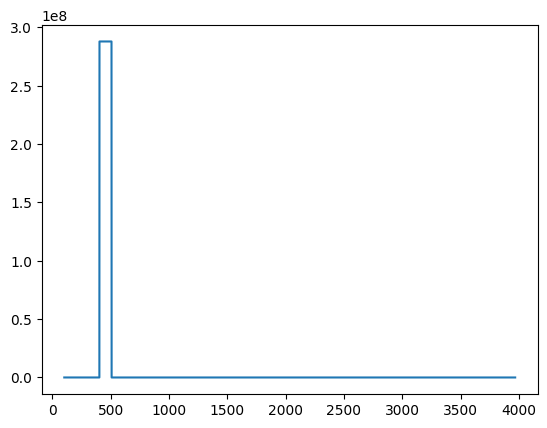

In [24]:
series = pd.Series(losses_memory).dropna()

# Calculate the rolling mean with a window of 500
rolling_mean = series.rolling(window=100).mean()
plt.plot(rolling_mean)

In [ ]:
diff_labels = []
for f in os.listdir("weapon-dataset/labels/validation/"):
    diff_labels.append(open("weapon-dataset/labels/validation/" + f).read().split(' ')[0])
np.unique(diff_labels)
# FUK

array(['', '0'], dtype='<U1')

In [ ]:
def update_class_numbers(directory):
    # Get a list of all txt files in the directory
    txt_files = [f for f in os.listdir(directory) if f.endswith('.txt')]

    for txt_file in txt_files:
        file_path = os.path.join(directory, txt_file)
        
        # Read the contents of the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Modify the class number to 0 if it is not already 0
        modified_lines = []
        for line in lines:
            if line.strip():  # Check if the line is not empty
                parts = line.split()
                if parts[0] != '0':
                    parts[0] = '0'
                modified_lines.append(' '.join(parts) + '\n')

        # Write the modified contents back to the file
        with open(file_path, 'w') as file:
            file.writelines(modified_lines)

directory_path = 'weapon-dataset/labels/train/'
update_class_numbers(directory_path)

In [ ]:

@torch.no_grad()
def test(args, params, model=None):
    filenames = []
    with open('../Dataset/COCO/val2017.txt') as reader:
        for filename in reader.readlines():
            filename = filename.rstrip().split('/')[-1]
            filenames.append('../Dataset/COCO/images/val2017/' + filename)

    dataset = Dataset(filenames, args.input_size, params, False)
    loader = data.DataLoader(dataset, 8, False, num_workers=8,
                             pin_memory=True, collate_fn=Dataset.collate_fn)

    if model is None:
        model = torch.load('./weights/best.pt', map_location='cuda')['model'].float()

    model.half()
    model.eval()

    # Configure
    iou_v = torch.linspace(0.5, 0.95, 10).cuda()  # iou vector for mAP@0.5:0.95
    n_iou = iou_v.numel()

    m_pre = 0.
    m_rec = 0.
    map50 = 0.
    mean_ap = 0.
    metrics = []
    p_bar = tqdm.tqdm(loader, desc=('%10s' * 3) % ('precision', 'recall', 'mAP'))
    for samples, targets, shapes in p_bar:
        samples = samples.cuda()
        targets = targets.cuda()
        samples = samples.half()  # uint8 to fp16/32
        samples = samples / 255  # 0 - 255 to 0.0 - 1.0
        _, _, height, width = samples.shape  # batch size, channels, height, width

        # Inference
        outputs = model(samples)

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height)).cuda()  # to pixels
        outputs = util.non_max_suppression(outputs, 0.001, 0.65)

        # Metrics
        for i, output in enumerate(outputs):
            labels = targets[targets[:, 0] == i, 1:]
            correct = torch.zeros(output.shape[0], n_iou, dtype=torch.bool).cuda()

            if output.shape[0] == 0:
                if labels.shape[0]:
                    metrics.append((correct, *torch.zeros((3, 0)).cuda()))
                continue

            detections = output.clone()
            util.scale(detections[:, :4], samples[i].shape[1:], shapes[i][0], shapes[i][1])

            # Evaluate
            if labels.shape[0]:
                tbox = labels[:, 1:5].clone()  # target boxes
                tbox[:, 0] = labels[:, 1] - labels[:, 3] / 2  # top left x
                tbox[:, 1] = labels[:, 2] - labels[:, 4] / 2  # top left y
                tbox[:, 2] = labels[:, 1] + labels[:, 3] / 2  # bottom right x
                tbox[:, 3] = labels[:, 2] + labels[:, 4] / 2  # bottom right y
                util.scale(tbox, samples[i].shape[1:], shapes[i][0], shapes[i][1])

                correct = numpy.zeros((detections.shape[0], iou_v.shape[0]))
                correct = correct.astype(bool)

                t_tensor = torch.cat((labels[:, 0:1], tbox), 1)
                iou = util.box_iou(t_tensor[:, 1:], detections[:, :4])
                correct_class = t_tensor[:, 0:1] == detections[:, 5]
                for j in range(len(iou_v)):
                    x = torch.where((iou >= iou_v[j]) & correct_class)
                    if x[0].shape[0]:
                        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1)
                        matches = matches.cpu().numpy()
                        if x[0].shape[0] > 1:
                            matches = matches[matches[:, 2].argsort()[::-1]]
                            matches = matches[numpy.unique(matches[:, 1], return_index=True)[1]]
                            matches = matches[numpy.unique(matches[:, 0], return_index=True)[1]]
                        correct[matches[:, 1].astype(int), j] = True
                correct = torch.tensor(correct, dtype=torch.bool, device=iou_v.device)
            metrics.append((correct, output[:, 4], output[:, 5], labels[:, 0]))

    # Compute metrics
    metrics = [torch.cat(x, 0).cpu().numpy() for x in zip(*metrics)]  # to numpy
    if len(metrics) and metrics[0].any():
        tp, fp, m_pre, m_rec, map50, mean_ap = util.compute_ap(*metrics)

    # Print results
    print('%10.3g' * 3 % (m_pre, m_rec, mean_ap))

    # Return results
    model.float()  # for training
    return map50, mean_ap
